<a href="https://colab.research.google.com/github/sweeya99/Autumn-of-Automation/blob/master/sunglasses_1_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [184]:
#!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
#import cv2
!pip install tensorboardcolab


In [185]:
import tensorflow as tf
from google.colab import drive
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from tensorflow.python.keras.callbacks import TensorBoard
from time import time
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from tensorflow.keras.callbacks import TensorBoard
from tensorboardcolab import * 
from keras.callbacks import TensorBoard
import time

In [186]:
from pylab import *
import cv2 
#from cv_bridge import CvBridge

In [187]:
drive.mount('/content/drive')
%cd '/content/drive/My Drive/SUNGLASSES'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/SUNGLASSES


In [188]:
h=112                            
b=112 

filenames_no=glob.glob("NO/*.pgm")     #Replace "soil" by your folder name.       

filenames_yes=glob.glob("YES/*.pgm")   #Replace broadleef by your folder name.

m1=len(filenames_no)
m2=len(filenames_yes)

image_data=np.zeros([m1+m2,b,h,3]) 
#print(image_data)   
y=np.zeros([m1+m2,1])
#print(y)

for i in range(m1):
  image=cv2.imread(filenames_no[i],1)
  image_data[i]=cv2.resize(image,(b,h))
  y[i]=0

for i in range(m2):
  image=cv2.imread(filenames_yes[i],1)
  image_data[m1+i]=cv2.resize(image,(b,h))
  y[m1+i]=1



In [189]:
data_gen=tf.keras.preprocessing.image.ImageDataGenerator(
    height_shift_range=0.2,
    width_shift_range=0.2,
    horizontal_flip=True,
    rotation_range=40,                                                
    shear_range=2,
    zoom_range=[0.9,1.2],
    fill_mode='constant',                                            #This defines how do we fill the vacant spaces. You will understand well when you plot the images                   
    cval=0.0,
    channel_shift_range=20     
) 

In [190]:
l=len(image_data)               #No. of images we took.
m=5                           #No. of artifically generated images
                                # generated per original image.

X_train=np.zeros([m*l,b,h,3])                                         #X_train is going to store all generated images.
y_train=np.zeros([m*l,1])
for i in range(m):                                                    #image_data.shape[0]=12
  it=data_gen.flow(image_data,y,batch_size=l)   
  #print(it)                      #'it' is an iterator to a tuple (X,y) which are the tranformed X and its corresponding y label
  temp=next(it)
  #print(temp)
  X_train[i*l:(i+1)*l,:,:,:]=temp[0]                                  #Well yeah this was hard to figure out, how to get the values of X and y. I just tried various things i
  y_train[i*l:(i+1)*l,:]=temp[1]                                      # could do with it (#pun) and after finite time it (#again) worked. xD 
                                                                      #So next(it) returns the tuple (X,y). Now we append them to X_train


In [191]:
num=len(y_train)
pos=np.arange(num)
print(pos)
np.random.shuffle(pos)        #As the name suggests , it shuffles the array.   
X_train=X_train[pos]
y_train=y_train[pos]

[   0    1    2 ... 3112 3113 3114]


[0.]
[1.]
[0.]
[0.]
[1.]
[0.]
[0.]
[0.]
[1.]
[1.]


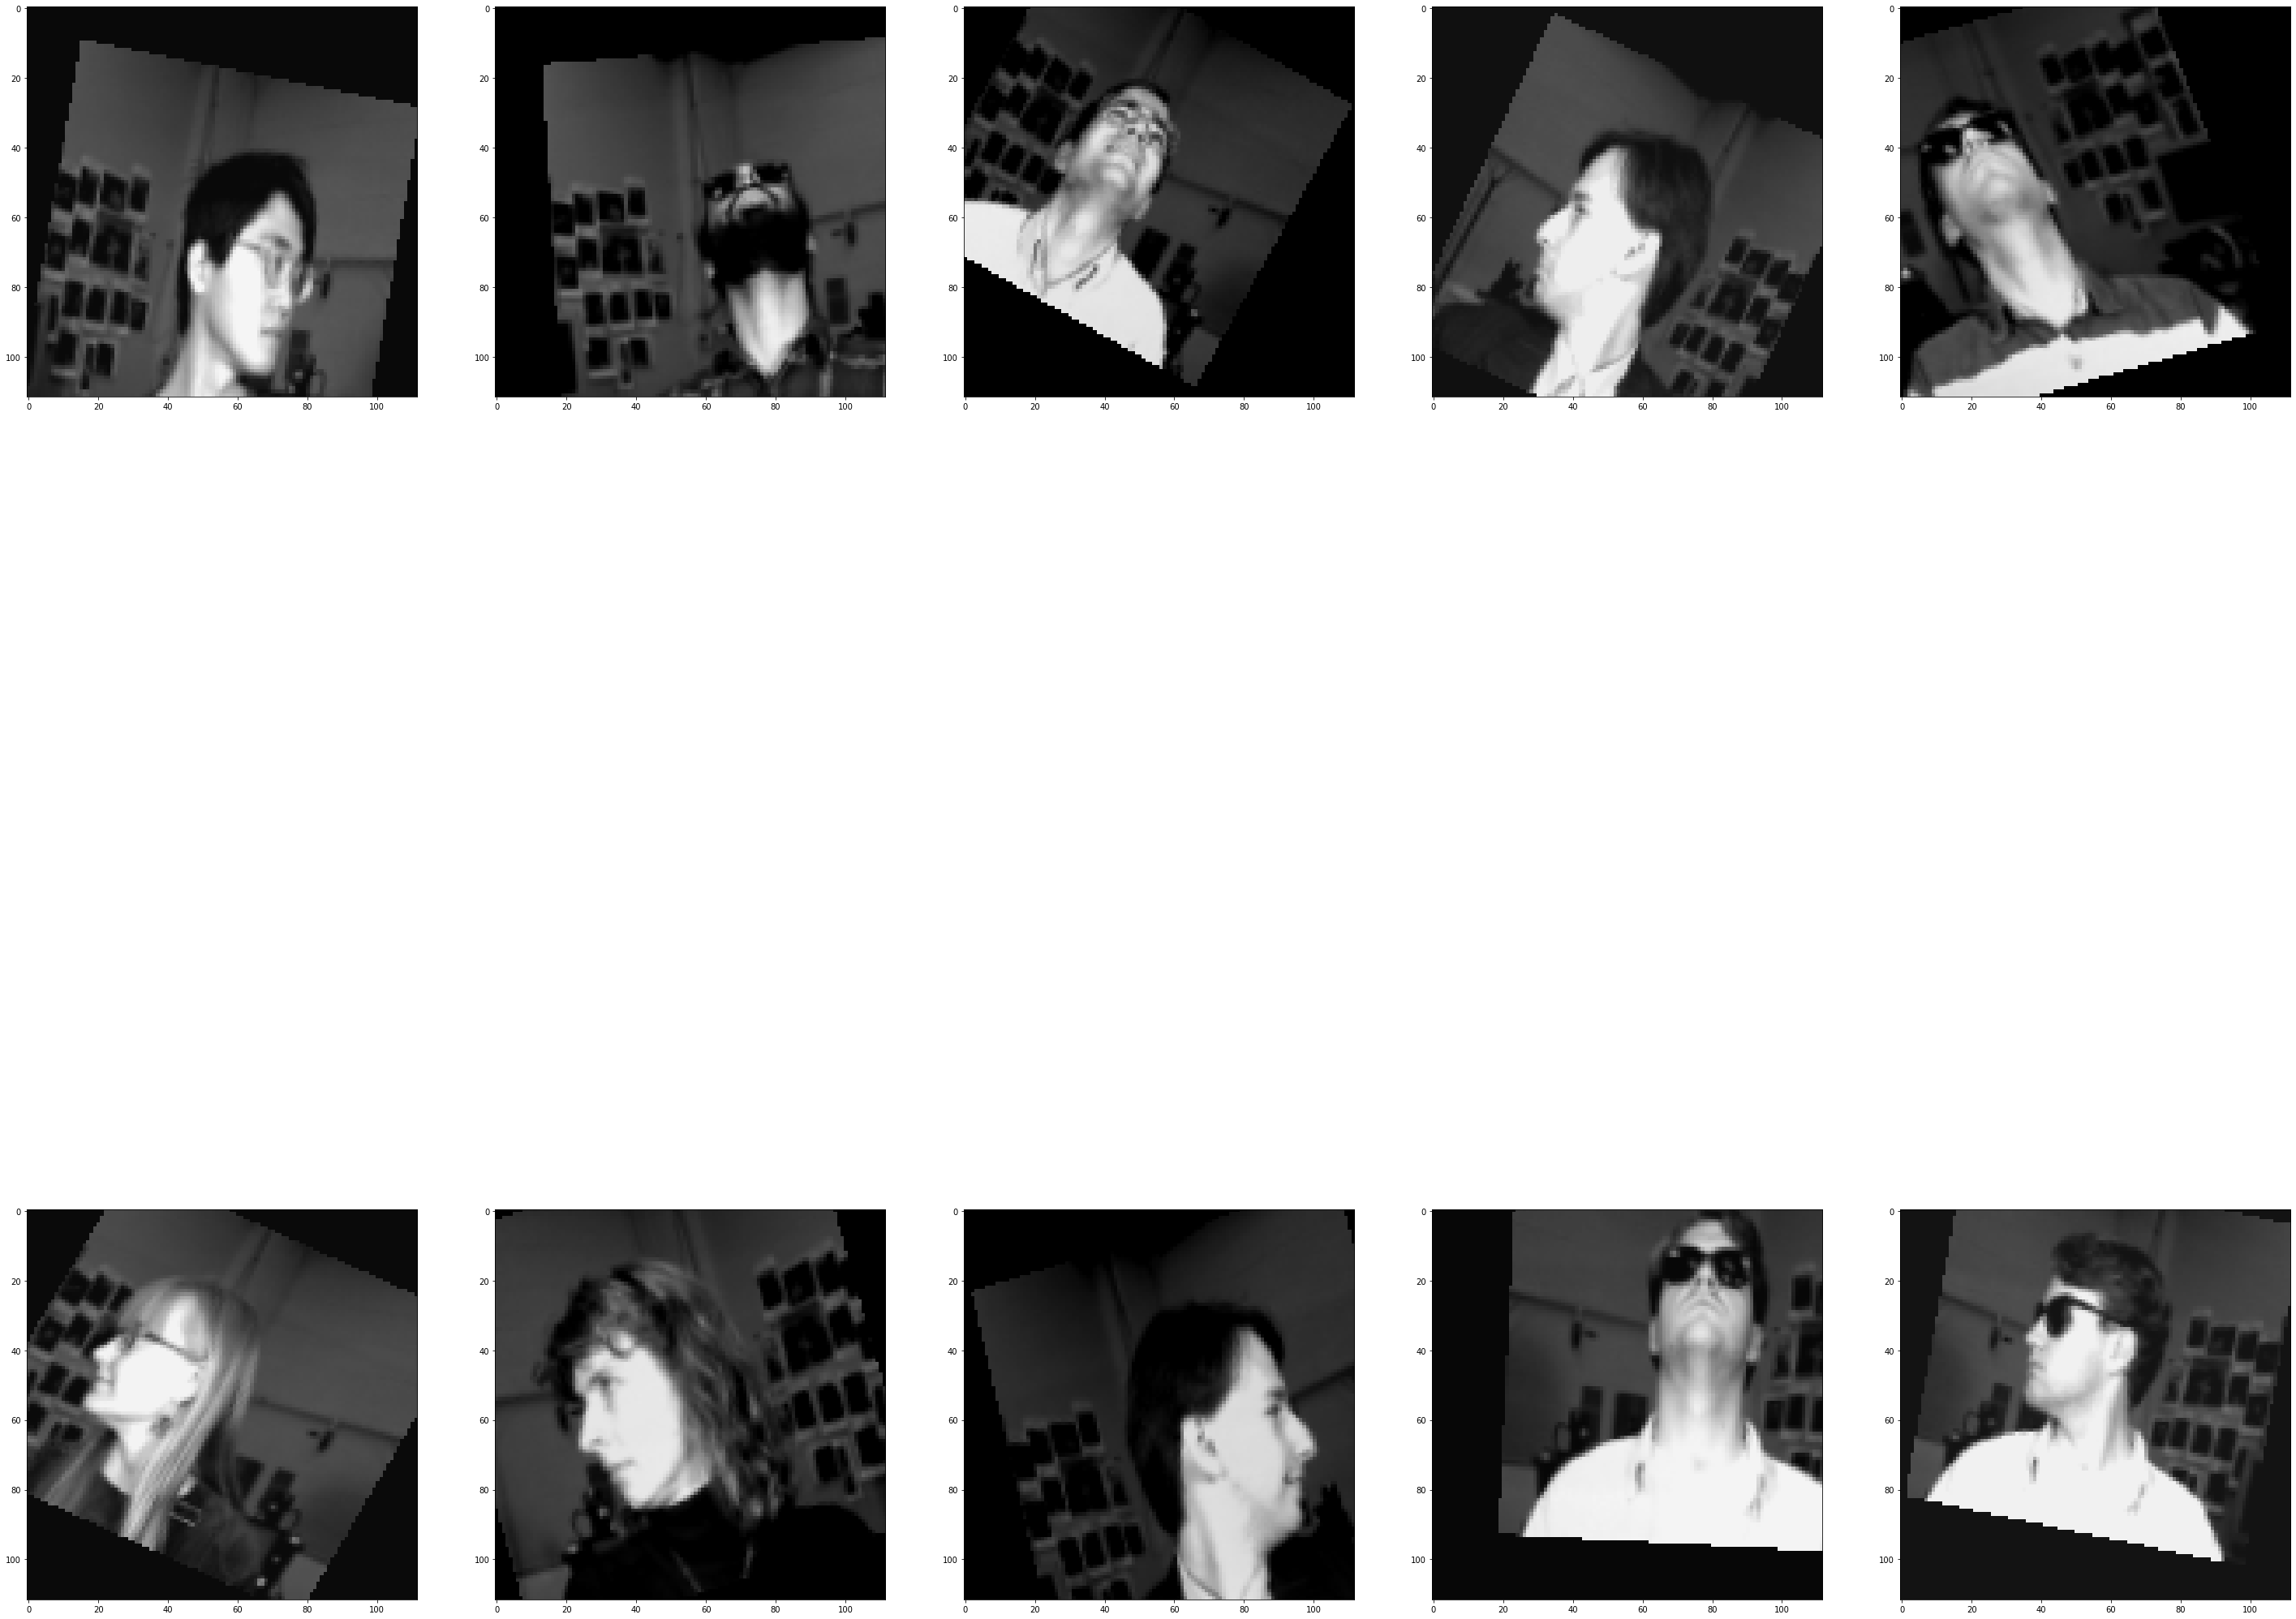

In [192]:
fig=plt.figure(figsize=(50,50))   #Crazy syntax alert! 
for i in range(10):
  sub=fig.add_subplot(2,5,i+1)
  sub.imshow(X_train[i*50+1,:,:,:].astype(np.uint8))        #A.astype(np.uint8) gives the same array A with the elements as an unsigned int of 8 bit i.e 0 to 255.
  print(y_train[i*50+1])

plt.show()

In [193]:
np.save('X_train',X_train)
np.save('y_train',y_train)

Next time onwards run the first two blocks and then start 

In [194]:
X_train=np.load('X_train.npy')
#print(X_train)
y_train=np.load('y_train.npy')
#print(y_train)

In [195]:
X_train = X_train.astype(np.uint8)
#print(X_train)
X_train_processed=tf.keras.applications.mobilenet_v2.preprocess_input(X_train)
#print(X_train_processed)

In [196]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),pooling='avg',weights='imagenet',include_top=False)
control=3
for layer in base_model.layers[:-control]:                                       
  layer.trainable=False                                                    #If control=m, this freezes all layers except last m layer. Try changing the value of control.
#base_model.summary()


In [197]:
from time import time

In [198]:
model=tf.keras.Sequential([                                                    
              base_model,
              #tf.keras.layers.GlobalAveragePooling2D(),
              #tf.keras.layers.Flatten(),                                  #As the name suggests it will change the shape from (b,h,3) to (h*B*3,1)
              #tf.keras.layers.Dense(n,activation='relu'),                #Again as the name suggests, its a fully connected layer. Relu is an activation function (as is sigmoid) 
              #tf.keras.layers.Dropout(0.2),                             #Dropout is some sort of regularization.   
              tf.keras.layers.Dense(1,activation='sigmoid')              #its the final layer which outputs a number in the range 0 to 1.
])

model.summary()
                                                                                         #Crazy Syntax
tensorboard = TensorBoard(log_dir="/logs/{}".format(time()))
model.compile(optimizer='adagrad',loss = 'binary_crossentropy',metrics=['accuracy'])   #if you have done andrew ng's course, binary cross entropy is the -ylog(h)-(1-y)log(1-h) loss. 
                                                                                     #'adagrad' is an advanced optimizing algorithm. In a nut shell its just a synthetic make up
                                                                                     # on 'adam' which is again a make up on gradient decent.
                                                                                     #try to run using adam :P
                                                                                     #metric is how would you evaluate the model. and accuracy gives how many labels predicted 
                                                                                     # were correct.

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 1280)              2257984   
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 3,841
Non-trainable params: 2,255,424
_________________________________________________________________


In [200]:

num=len(y_train)               #num is the no. of images.
frac=int(num*0.8)              #frac is the no. of images we use for training and remaining for validation

tic=time()
epochs=12       #epochs is the just the no. of times you do gradient descent over entire batch. 
                #Larger epoch, better accuracy(on training set) but more time to run and if it is too large then lower validation accuracy.
#X_train_processed, X_test, y_train, y_test 
#    = train_test_split(X_train_processed, y_train, test_size=0.2, random_state=1)

#X_train_processed, X_val, y_train, y_val 
#    = train_test_split(X_train_processed, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

model.fit(X_train_processed,                                                        #X_train_processed[0:frac],
          y_train                                                                         #y_train[0:frac],
          validation_data=(X_val,y_val) ,                                 #  X_train_processed[frac:num],y_train[frac:num]),
          #validation_data=(X_validation,y_validation),
          batch_size=8,                                                      #Its the mini-batch size. So you update the gradient after 16 iterations.
          epochs=epochs,
          callbacks=[tensorboard])  


toc=time()
print('Total time for gradient descent=',toc-tic)
train, validate, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])



IndentationError: ignored

In [ ]:
%load_ext tensorboard             
%tensorboard --logdir logs 
%reload_ext tensorboard       
#This is a tricky the thing and its confusing me even now xD. So if you see no output (not even blank tensorboard screen or some error message
# which asks you to reload) i.e completely blank, then run this. Else clear the output and run this.

In [ ]:
img=cv2.imread('/content/drive/My Drive/SUNGLASSES/NO/NoSunglasses0.pgm',1)
##img=cv2.resize(b,h)
img= cv2.resize(img,(b,h))
img = img.astype(np.uint8)
img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
image=np.zeros([1,b,h,3])
image[0]=img
predictions=model.predict(image)
print(predictions)
##model.predict(img)
##prediction=model.predict([[img]])



In [ ]:
#model.save("my_model.h5")